In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.rcParams['font.size']=16

def initskip_olg():
    os.system("grep -n -i 'LIST OF TERMS WITH A WEIGHTED MEAN OVER THE FINE STRUCTURE' olg > dum.txt")
    dumline=pd.read_csv("dum.txt",header=None,sep='\s+')
    nrows=len(dumline)
    iline=dumline.loc[nrows-1][0]
    os.system("rm dum.txt")
    return int(iline[0:-1])

def determine_parity(df,ip):
    df.insert(ip,'P',-1)
    odd=df.index[df.loc[:]['2S+1']<0].tolist()
    even=df.index[df.loc[:]['2S+1']>0].tolist()
    for i in odd: df.at[i,'P']=1
    for i in even: df.at[i,'P']=0
    return

def termsymbol_to_quantnumber(chterm):
    chsq=chterm[0]
    chlq=chterm[1]
    # multiplicity 2S+1
    sq=int(chsq)
    # angular momenta L
    if chlq=='S': lq=0
    if chlq=='P': lq=1
    if chlq=='D': lq=2
    if chlq=='F': lq=3
    if chlq=='G': lq=4
    if chlq=='H': lq=5
    if chlq=='I': lq=6
    if chlq=='K': lq=7
    # parity
    if (lq%2)==0: pq=0
    if (lq%2)!=0: pq=1
    return sq,lq,pq

def quantnumber_to_termsymbol(sq,lq,pq):
    # multiplicity 2S+1
    chsq=str(int(sq))
    # angular momenta L
    if lq==0: chlq='S'
    if lq==1: chlq='P'
    if lq==2: chlq='D'
    if lq==3: chlq='F'
    if lq==4: chlq='G'
    if lq==5: chlq='H'
    if lq==6: chlq='I'
    if lq==7: chlq='K'
    # parity
    if pq==0: chpq=''
    if pq!=0: chpq='*'
    chterm=chsq+chlq+chpq
    return chterm

## Input NIST level and configuration data

In [2]:
nist_levs=pd.read_csv("../NIST_levels.dat",sep='\s+',skiprows=[0,2],header='infer')
nist_cfgs=pd.read_csv("../NIST_cfgs.dat",sep='\s+',skiprows=[0,2],header='infer')
nist_levs.rename(columns={"Level(Ry)":"NIST(Ryd)"},inplace=True)
nist_levs.rename(columns={"Configuration":"Conf"},inplace=True)
nlevnist=len(nist_levs)
# match configuration with AutoStructure labeling and decode spectroscopic terms to quantum numbers
cf=[]
sq=[]
lq=[]
pq=[]
for i in range(nlevnist):
    dumcf=nist_levs.loc[i]['Conf']
    dumterm=nist_levs.loc[i]['Term']
    sqq,lqq,pqq=termsymbol_to_quantnumber(dumterm)
    icfg=nist_cfgs.loc[nist_cfgs.loc[:]['CFG']==dumcf]['i'].tolist()
    sq.append(sqq)
    lq.append(lqq)
    pq.append(pqq)
    cf.append(icfg[0])
# insert new columns into NIST dataframe
nist_levs.insert(2,'2S+1',sq)
nist_levs.insert(3,'L',lq)
nist_levs.insert(4,'P',pq)
nist_levs.insert(5,'CF',cf)

In [3]:
nist_levs.head()

,Conf,Term,2S+1,L,P,CF,J,NIST(Ryd)
0,3s2,1S,1,0,0,1,0,0.000000
1,3s.3p,3P*,3,1,1,2,0,0.199116
2,3s.3p,3P*,3,1,1,2,1,0.199298
3,3s.3p,3P*,3,1,1,2,2,0.199669
4,3s.3p,1P*,1,1,1,2,1,0.319411


## Create NIST terms dataframe from NIST levels

In [4]:
nist_terms=nist_levs.drop_duplicates(subset=['Conf','Term'],keep='first')
nist_terms.reset_index(drop=True,inplace=True)
# compute weighted energy and J quantum number for each term
ntermnist=len(nist_terms)
for i in range(ntermnist):
    dumterm=nist_terms.loc[i][:]
    dumlev=nist_levs.loc[(nist_levs.loc[:]['Conf']==dumterm['Conf'])
                        &(nist_levs.loc[:]['Term']==dumterm['Term'])]
    dumlev.reset_index(drop=True,inplace=True)
    ndumlev=len(dumlev)
    sum_giei=0.
    sum_gi=0
    for j in range(ndumlev):
        gi=2*dumlev.loc[j]['J']+1
        ei=dumlev.loc[j]['NIST(Ryd)']
        sum_gi=sum_gi+gi
        sum_giei=sum_giei+gi*ei
    eiterm=sum_giei/sum_gi
    jiterm=(sum_gi-1)/2
    nist_terms.at[i,'NIST(Ryd)']=eiterm
    nist_terms.at[i,'J']=jiterm

In [5]:
nist_terms.head()

,Conf,Term,2S+1,L,P,CF,J,NIST(Ryd)
0,3s2,1S,1,0,0,1,0,0.000000
1,3s.3p,3P*,3,1,1,2,4,0.199484
2,3s.3p,1P*,1,1,1,2,1,0.319411
3,3s.4s,3S,3,0,0,4,1,0.375418
4,3s.4s,1S,1,0,0,4,0,0.396432


## Input AutoStructure levels and terms

In [6]:
ndum=6
ncfgs=85
nlevs=339
as_levs=pd.read_csv("oic",sep='\s+',skiprows=ncfgs+ndum,header='infer',nrows=nlevs)
determine_parity(as_levs,5)
as_levs.loc[:]['2S+1']=abs(as_levs.loc[:]['2S+1'])
as_levs.rename(columns={"(EK-E1)/RY":"AS(Ryd)"},inplace=True)
nlevs=len(as_levs)

In [7]:
as_levs.head()

,K,LV,T,2S+1,L,P,2J,CF,AS(Ryd)
0,1,298,169,1,0,0,0,1,0.000000
1,2,319,108,3,1,1,0,2,0.199244
2,3,253,108,3,1,1,2,2,0.199364
3,4,188,108,3,1,1,4,2,0.199604
4,5,274,130,1,1,1,2,2,0.319411


In [8]:
nterms=189
initskip=initskip_olg()
tcols=[i for i in range(8)]
as_terms=pd.read_csv("olg",sep='\s+',skiprows=initskip,header='infer',nrows=nterms,usecols=tcols)
determine_parity(as_terms,5)
as_terms.loc[:]['2S+1']=abs(as_terms.loc[:]['2S+1'])
as_terms.rename(columns={"(EI-E1)/RY":"AS(Ryd)"},inplace=True)
nterms=len(as_terms)
as_terms.drop(['K*CM','WEIGHTS'],axis=1,inplace=True)

In [9]:
as_terms.head()

,I,T,2S+1,L,P,CF,AS(Ryd)
0,1,169,1,0,0,1,0.000000
1,2,108,3,1,1,2,0.199484
2,3,130,1,1,1,2,0.319411
3,4,151,3,0,0,4,0.375418
4,5,170,1,0,0,4,0.396432


## Include NIST energy levels in AutoStructure levels dataframe

In [10]:
# include new column to match NIST energy levels
iflag=-1
ncols=len(as_levs.columns)
as_levs.insert(ncols,'NIST(Ryd)',iflag)
as_levs['NIST(Ryd)']=as_levs['NIST(Ryd)'].astype(float)
# match multiplicity, angular momenta, J and configuration between NIST and AutoStructure
for i in range(nlevs):
    dumnist=nist_levs[
           (nist_levs.loc[:]['2S+1']==as_levs.loc[i]['2S+1']) & 
           (nist_levs.loc[:]['L']   ==as_levs.loc[i]['L'])    & 
           (2*nist_levs.loc[:]['J'] ==as_levs.loc[i]['2J'])   & 
           (nist_levs.loc[:]['CF']  ==as_levs.loc[i]['CF'])][:]
    if len(dumnist)==1:
        as_levs.at[i,'NIST(Ryd)']=float(dumnist.iloc[0]['NIST(Ryd)'])

## Include NIST energy terms in AutoStructure terms dataframe

In [11]:
# include new column to match NIST energy terms
iflag=-1
ncols=len(as_terms.columns)
as_terms.insert(ncols,'NIST(Ryd)',iflag)
as_terms['NIST(Ryd)']=as_terms['NIST(Ryd)'].astype(float)
# match multiplicity, angular momenta and configuration between NIST and AutoStructure
for i in range(nterms):
    dumnist=nist_terms[
           (nist_terms.loc[:]['2S+1']==as_terms.loc[i]['2S+1']) & 
           (nist_terms.loc[:]['L']   ==as_terms.loc[i]['L'])    & 
           (nist_terms.loc[:]['CF']  ==as_terms.loc[i]['CF'])][:]
    if len(dumnist)==1:
        as_terms.at[i,'NIST(Ryd)']=float(dumnist.iloc[0]['NIST(Ryd)'])

## Create pseudo Database dataframe with NIST and AS data

In [12]:
db_levs=as_levs.copy()
# drop lv and t columns and insert configuration and term columns
db_levs.drop(["LV","T"],axis=1,inplace=True)
db_levs.insert(1,'Conf','x')
db_levs.insert(2,'Term','x')
# drop all levels and terms higher than 3s.20d
ncfgmax=79
droplev=db_levs.index[db_levs.loc[:]['CF']>ncfgmax].tolist()
db_levs.drop(droplev,axis=0,inplace=True)
db_levs.reset_index(drop=True,inplace=True)
# fill configuration and term symbols 
ndblevs=len(db_levs)
for i in range(ndblevs):
    sq=db_levs.iloc[i]['2S+1']
    lq=db_levs.iloc[i]['L']
    pq=db_levs.iloc[i]['P']
    icf=db_levs.iloc[i]['CF']
    term=quantnumber_to_termsymbol(sq,lq,pq)
    cf=nist_cfgs.loc[nist_cfgs.loc[:]['i']==icf]['CFG'].tolist()
    db_levs.at[i,'Term']=term
    db_levs.at[i,'Conf']=cf[0]

db_terms=as_terms.copy()
db_terms.drop(["T"],axis=1,inplace=True)
db_terms.insert(1,'Conf','x')
db_terms.insert(2,'Term','x')
dropterm=db_terms.index[db_terms.loc[:]['CF']>ncfgmax].tolist()
db_terms.drop(dropterm,axis=0,inplace=True)
db_terms.reset_index(drop=True,inplace=True)
ndbterms=len(db_terms)
for i in range(ndbterms):
    sq=db_terms.iloc[i]['2S+1']
    lq=db_terms.iloc[i]['L']
    pq=db_terms.iloc[i]['P']
    icf=db_terms.iloc[i]['CF']
    term=quantnumber_to_termsymbol(sq,lq,pq)
    cf=nist_cfgs.loc[nist_cfgs.loc[:]['i']==icf]['CFG'].tolist()
    db_terms.at[i,'Term']=term
    db_terms.at[i,'Conf']=cf[0]

In [13]:
# copy NIST energy levels to pseudo database dataframe
db_levs['Energy']=db_levs['NIST(Ryd)']
# copy computed (with ISHFTLS) energy levels:
imiss_levs=db_levs.index[db_levs.loc[:]['Energy']==-1].tolist()
for i in imiss_levs:
    db_levs.at[i,'Energy']=db_levs.loc[i]['AS(Ryd)']
# check if there is any missing energy level
icheck_levs=db_levs.loc[db_levs.loc[:]['Energy']==-1]
if len(icheck_levs)!=0: print("missing: ",icheck_levs)

# copy NIST energy terms to pseudo database dataframe
db_terms['Energy']=db_terms['NIST(Ryd)']
# copy computed (with ISHFTLS) energy levels:
imiss_terms=db_terms.index[db_terms.loc[:]['Energy']==-1].tolist()
for i in imiss_terms:
    db_terms.at[i,'Energy']=db_terms.loc[i]['AS(Ryd)']
# check if there is any missing energy terms
icheck_terms=db_terms.loc[db_terms.loc[:]['Energy']==-1]
if len(icheck_terms)!=0: print("missing: ",icheck_terms)

In [14]:
db_levs.head()

,K,Conf,Term,2S+1,L,P,2J,CF,AS(Ryd),NIST(Ryd),Energy
0,1,3s2,1S,1,0,0,0,1,0.000000,0.000000,0.000000
1,2,3s.3p,3P*,3,1,1,0,2,0.199244,0.199116,0.199116
2,3,3s.3p,3P*,3,1,1,2,2,0.199364,0.199298,0.199298
3,4,3s.3p,3P*,3,1,1,4,2,0.199604,0.199669,0.199669
4,5,3s.3p,1P*,1,1,1,2,2,0.319411,0.319411,0.319411


In [15]:
db_terms.head()

,I,Conf,Term,2S+1,L,P,CF,AS(Ryd),NIST(Ryd),Energy
0,1,3s2,1S,1,0,0,1,0.000000,0.000000,0.000000
1,2,3s.3p,3P*,3,1,1,2,0.199484,0.199484,0.199484
2,3,3s.3p,1P*,1,1,1,2,0.319411,0.319411,0.319411
3,4,3s.4s,3S,3,0,0,4,0.375418,0.375418,0.375418
4,5,3s.4s,1S,1,0,0,4,0.396432,0.396432,0.396432


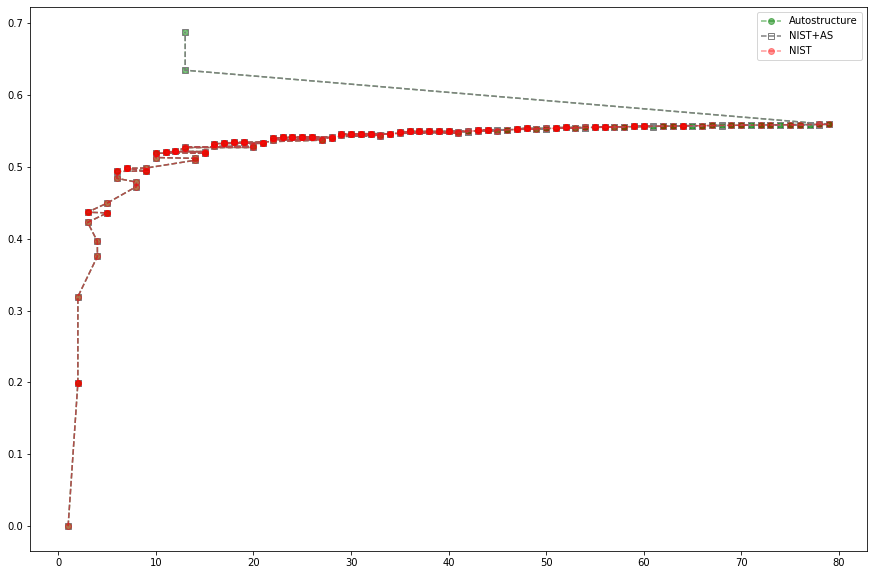

In [16]:
fig=plt.figure(figsize=(15,10))
plt.plot(db_levs["CF"],db_levs["AS(Ryd)"],'go',linestyle='dashed',alpha=0.5,label='Autostructure')
plt.plot(db_levs["CF"],db_levs["Energy"],marker='s',color='tab:gray', markerfacecolor='none',
         linestyle='dashed',label='NIST+AS')
plt.plot(nist_levs["CF"],nist_levs["NIST(Ryd)"],'ro',linestyle='dashed',alpha=0.4,label='NIST')
plt.legend(loc='best')
plt.show()

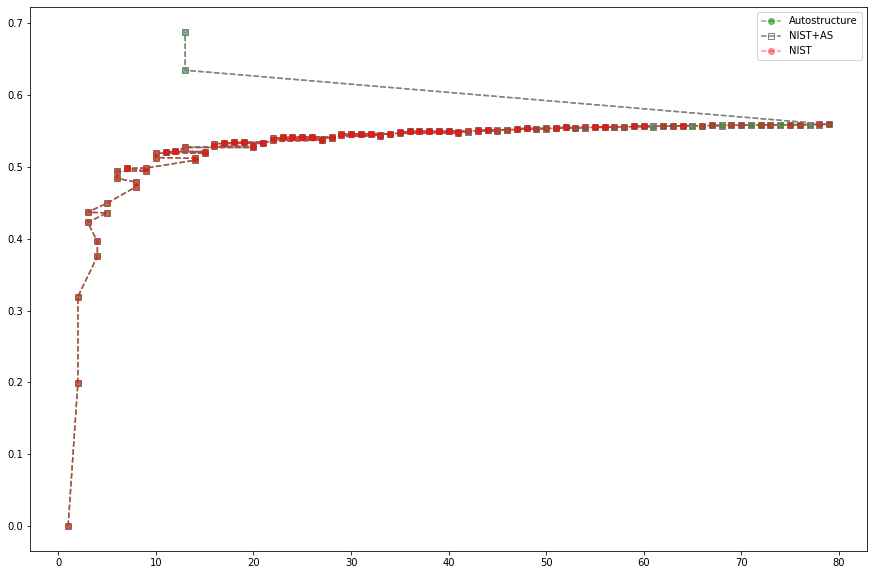

In [17]:
fig=plt.figure(figsize=(15,10))
plt.plot(db_terms["CF"],db_terms["AS(Ryd)"],'go',linestyle='dashed',alpha=0.5,label='Autostructure')
plt.plot(db_levs["CF"],db_levs["Energy"],marker='s',color='tab:gray', markerfacecolor='none',
         linestyle='dashed',label='NIST+AS')
plt.plot(nist_terms["CF"],nist_terms["NIST(Ryd)"],'ro',linestyle='dashed',alpha=0.4,label='NIST')
plt.legend(loc='best')
plt.show()

## Print pseudo Database terms and levels dataframe

In [18]:
db_levs.to_csv('NIST+AS_levels.dat',index=False,sep='\t',header=True,float_format='%.6f')
db_terms.to_csv('NIST+AS_terms.dat',index=False,sep='\t',header=True,float_format='%.6f')